In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading the data

In [2]:
train_path = "/kaggle/input/skin-cancer-malignant-vs-benign/train"
train_paths, train_labels = [], []
for i in os.listdir(train_path):
    for j in os.walk(os.path.join(train_path, i)):
        for k in j[2]:
            train_paths.append(os.path.join(train_path, i, k))
            train_labels.append(i)
            
val_path = "/kaggle/input/skin-cancer-malignant-vs-benign/test"
val_paths, val_labels = [], []
for i in os.listdir(val_path):
    for j in os.walk(os.path.join(val_path, i)):
        for k in j[2]:
            val_paths.append(os.path.join(val_path, i, k))
            val_labels.append(i)

### Creating the Dataset Class

In [3]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Class to load the dataset
class Dataset(Dataset):
    def __init__(self, paths, labels, mode="train"):
        self.paths = paths
        self.labels = labels
        self.mode = mode
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.paths[idx])
        image = image.resize((256, 256))
        
        if self.mode == "train":
            # Data Augmentation
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = preprocess(image)
        else:
            preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
        label = [0., 1.] if self.labels[idx]=='malignant' else [1., 0.]
        label = torch.tensor(label)
        return image, label
    
# Creating training and validation datasets
train_data = Dataset(train_paths, train_labels)
val_data = Dataset(val_paths, val_labels)

# Creating dataloader classes
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)

### Applying VGG-16 Pre-trained Model

In [4]:
import torch.nn as nn
from torchvision import models

# Loading the pre-trained VGG model
vgg = models.vgg16(weights=True)
# Looking at the classifier module
vgg.classifier

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 165MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

We will replace the last layer with a layer that has `out_features=2`.

In [5]:
# Freezing the previous layers
vgg.features.requires_grad_(False)

# Creating a model for finetuning
class DownstreamSequential(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 2)
        
        self.bn1 = nn.BatchNorm1d(4096)
        self.bn2 = nn.BatchNorm1d(2048)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(128)
        self.bn7 = nn.BatchNorm1d(2)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, input_t):
        x = self.relu(self.bn1(self.fc1(input_t)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.dropout(x)
        x = self.relu(self.bn7(self.fc7(x)))
        x = self.dropout(x)
        return x


# Replacing the sequential model
vgg.classifier = DownstreamSequential()

# Compiling the model
vgg.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Writing the Training Loop (Fine-tuning)

In [6]:
from tqdm.auto import tqdm

optimizer = torch.optim.AdamW(vgg.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    total_steps=len(train_dataloader)*20,
    final_div_factor=1.0,
)

# Enabling GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)

# Keeping track of loss
loss_l = []


for epoch in range(20):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for img, label in pbar:
        img = img.to(device)
        label = label.to(device)
        
        outputs = vgg(img)
        loss = criterion(outputs, label)
        loss_l.append(loss.detach().to("cpu"))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        del img
        del label
        
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

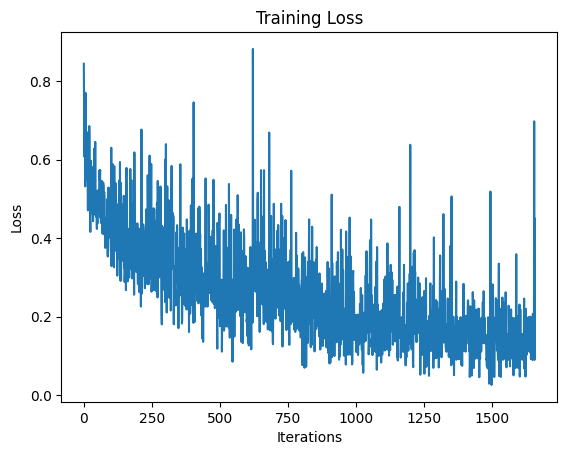

In [7]:
# Plotting the loss
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(loss_l)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

### Writing the Evaluation Loop

In [8]:
from sklearn.metrics import classification_report

# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    y_true, y_pred = [], []
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            y_pred.extend(torch.argmax(outputs, dim=1).to("cpu"))
            y_true.extend(torch.argmax(labels, dim=1).to("cpu"))
    # Calculating metrics
    print(classification_report(y_true, y_pred))
    
evaluate(vgg, val_dataloader, criterion)

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       360
           1       0.85      0.85      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660



### Custom CNN

In [9]:
from tqdm.auto import tqdm
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding="same")

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(start_dim=1)

        self.dense1 = nn.LazyLinear(512)
        self.dense2 = nn.Linear(512, 512)

        self.silu = nn.SiLU()
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(512, 2)

        # Batch normalization layers after convolutions
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

    def forward(self, input_t):
        x = self.silu(self.bn1(self.pool(self.conv1(input_t))))
        x = self.silu(self.bn2(self.pool(self.conv2(x))))
        x = self.silu(self.bn3(self.pool(self.conv3(x))))
        x = self.silu(self.bn4(self.pool(self.conv4(x))))
        x = self.flatten(x)
        x = self.silu(self.dense1(x))
        x = self.dropout(x)
        x = self.silu(self.dense2(x))
        x = self.dropout(x)
        x = self.softmax(self.classifier(x))
        return x
    
# Creating the model
model = CustomCNN(3)
model = model.to(device)

# Initializing the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Creating a learning rate scheduler
total_batches = len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.01, 
    total_steps=total_batches * 20, 
    final_div_factor=10.0
)

# Keeping track of the loss
loss_l = []

# Training loop
for epoch in range(20):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for image, label in pbar:
        # Moving the data to GPU
        image = image.to(device)
        label = label.to(device)
        
        # Forward pass
        outputs = model(image)
        loss = criterion(outputs, label)
        loss_l.append(loss.detach().to("cpu"))
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Learning rate scheduler
        lr_scheduler.step()
        
        del image
        del label
        
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item()}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

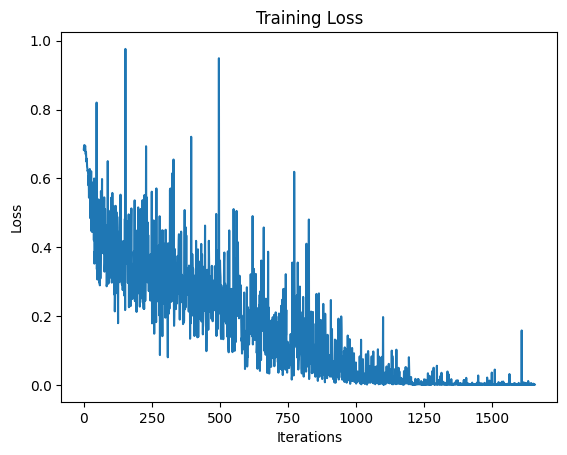

In [10]:
# Plotting the loss
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(loss_l)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [11]:
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    y_true, y_pred = [], []
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            y_pred.extend(torch.argmax(outputs, dim=1).to("cpu"))
            y_true.extend(torch.argmax(labels, dim=1).to("cpu"))
    # Calculating metrics
    print(classification_report(y_true, y_pred))
    
evaluate(model, val_dataloader, criterion)

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       360
           1       0.81      0.86      0.83       300

    accuracy                           0.85       660
   macro avg       0.84      0.85      0.84       660
weighted avg       0.85      0.85      0.85       660



# End